# Program 2: Game Playing

**Justin Hoang**  
**CSCI 4202**  
**10/20/24**  

### Connect Four
The standard game of connect four, where players have to connect their four pieces in a row. The four pieces can be arranged either vertically, horizontally, or diagonally.  

### Description of Program
This program plays against another AI program in the game of connect four.  
I use alpha-beta pruning to determine the best move to play on the board.  

The program can handle board sizes from 4x4 up to 16x16  

### IMPORTANT NOTE  
This program will ***NOT*** run in the Jupyter Notebook. The notebook is just for the report, detailing my program and its results.  

I provided the source code separately called `HoangProgram2.py`.

## Program Design:

In [1]:
# import necessary packages
import sys
import json
import random

### Command Line Parsing
These lines parse the command-line arguments given by the driver to set up the key game parameters.  

player is expected to be either 1 or 2
width is the expected width of the game board
height is the expect height of the game board

In [ ]:
player = int(sys.argv[2])
width = int(sys.argv[4])
height = int(sys.argv[6])

In [ ]:
sys.stderr.write(f"player = {player}\n")
sys.stderr.write(f" width = {width}\n")
sys.stderr.write(f"height = {height}\n")

### Opponent Identification
Determines the opponent's player number.  

If player is 1, opponent will be 2  
If player is 2, opponent will be 1

In [ ]:
opponent = 3 - player

### Valid Moves
This function takes in a list, checking the top row of each column of the grid and returns a list of valid column indices that the player can make.

In [ ]:
def valid_moves(grid):
    return [col for col in range(width) if grid[col][0] == 0]

### Drop Piece
This function "simulates" gravity by checking the board from bottom to top, returning the row where the piece will land.

In [ ]:
def drop_piece(grid, col, piece):
    for row in range(height-1, -1, -1):
        if grid[col][row] == 0:
            return row
    return -1

### Check Winner
This function checks only the last move made, checking for four pieces of the same player in row vertically, horizontally, or diagonally.  

It will stop the game once a win is found.

In [ ]:
def check_winner(grid, col, row, piece):
    # check horizontal
    count = 0
    for c in range(max(0, col-3), min(width, col+4)):
        if grid[c][row] == piece:
            count += 1
            if count == 4:
                return True
        else:
            count = 0
    
    # check vertical
    if row <= height - 4:
        if all(grid[col][row+i] == piece for i in range(4)):
            return True
    
    # check diagonal (positive slope)
    count = 0
    for i in range(-3, 4):
        if 0 <= col+i < width and 0 <= row+i < height:
            if grid[col+i][row+i] == piece:
                count += 1
                if count == 4:
                    return True
            else:
                count = 0
    
    # check diagonal (negative slope)
    count = 0
    for i in range(-3, 4):
        if 0 <= col+i < width and 0 <= row-i < height:
            if grid[col+i][row-i] == piece:
                count += 1
                if count == 4:
                    return True
            else:
                count = 0
    
    return False


### Evaluate Position
This is a simple heuristic function that will favor the center position for control of the board.  

It assigns higher scores to pieces closer to the center.  

**Note**  
I found a video on youtube that implemented connect four specifically using alpha-beta pruning, kind of similar, but not exactly, to this assignment. It used this heuristic here and I had ChatGPT help me a little bit to implement it to my program.  

[YouTube Link](https://www.youtube.com/watch?v=rbmk1qtVEmg)

In [ ]:
def evaluate_position(grid):
    score = 0
    for col in range(width):
        for row in range(height):
            if grid[col][row] == player:
                score += col + 1  # prefer center columns
            elif grid[col][row] == opponent:
                score -= col + 1
    return score

### Alpha-Beta Pruning
The function incorporates alpha-beta pruning, an optimized algorithm of min-max.  

It is recursively called, calling itself over and over again until a winner (or a draw) is found.  

It incorporates the early termination for winning moves (`check_winner` function), the `drop_piece` function, and the huerisitc (`evaluate_position`) to find the best move to play.  

Alpha-beta pruning speeds up the minimax algorithm by skipping move sequences that won't affect the final choice. If a good move is found, branches that are guaranteed to be worse can be ignored completely. This lets the AI look further ahead while examining far fewer positions. In the code, this happens when `alpha >= beta`, which means "this branch can't be better than what we already found."

In [ ]:
def alpha_beta(grid, depth, alpha, beta, maximizing_player):
    valid_moves_list = valid_moves(grid)
    if depth == 0 or not valid_moves_list:
        return evaluate_position(grid)
    
    if maximizing_player:
        value = float('-inf')
        for move in valid_moves_list:
            row = drop_piece(grid, move, player)
            grid[move][row] = player
            if check_winner(grid, move, row, player):
                grid[move][row] = 0
                return float('inf')
            value = max(value, alpha_beta(grid, depth - 1, alpha, beta, False))
            grid[move][row] = 0
            alpha = max(alpha, value)
            if alpha >= beta:
                break
        return value
    else:
        value = float('inf')
        for move in valid_moves_list:
            row = drop_piece(grid, move, opponent)
            grid[move][row] = opponent
            if check_winner(grid, move, row, opponent):
                grid[move][row] = 0
                return float('-inf')
            value = min(value, alpha_beta(grid, depth - 1, alpha, beta, True))
            grid[move][row] = 0
            beta = min(beta, value)
            if beta <= alpha:
                break
        return value

### Best Move
This function evaluates all valid moves, using the alpha-beta pruning and keeps track of moves with **equal** best scores.  

It will randomly select from best moves.

In [ ]:
def best_move(grid):
    valid_moves_list = valid_moves(grid)
    best_score = float('-inf')
    best_moves = []
    
    for move in valid_moves_list:
        row = drop_piece(grid, move, player)
        grid[move][row] = player
        
        if check_winner(grid, move, row, player):
            grid[move][row] = 0
            return move
        
        score = alpha_beta(grid, 5, float('-inf'), float('inf'), False)
        grid[move][row] = 0
        
        if score > best_score:
            best_score = score
            best_moves = [move]
        elif score == best_score:
            best_moves.append(move)
    
    return random.choice(best_moves)

### Main Game Loop
This loop reads the JSON input from the game driver, and outputs it back into JSON for the driver.  

In [ ]:
for line in sys.stdin:
    sys.stderr.write(line)
    state = json.loads(line)
    action = {"move": best_move(state['grid'])}
    msg = json.dumps(action)
    sys.stderr.write(msg + '\n')
    sys.stdout.write(msg + '\n')
    sys.stdout.flush()

In [ ]:
sys.stdin.close()
sys.stdout.close()
sys.stderr.close()

# Results

For the results of different board sizes, the smaller the board, the quicker the game would finish playing out, and vice versa for larger boards.  

The results are tested against the naive player, my own program itself, and another student's program.

## Results against other players
These games are tested on a 6x7 board.  

### Against Naive Player
When playing my program against the naive player, my player wins every single time, even in the case of the naive player going first. This happens consistently.  

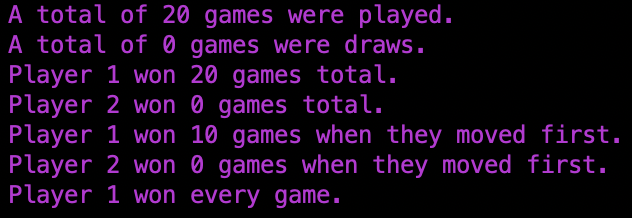

### Against Own Program
When playing my program against itself, the results are mixed.  

There were actually a lot of draws. I believe that is the case because since my program uses a heuristic that favors the center of the board (for control), that both of the programs would be fighting for the same positions on the board, therefore rather than trying to find winning moves, rather it just fights for control of the center.  

The order of which player went first did not seem to matter or give either player an advantage.  

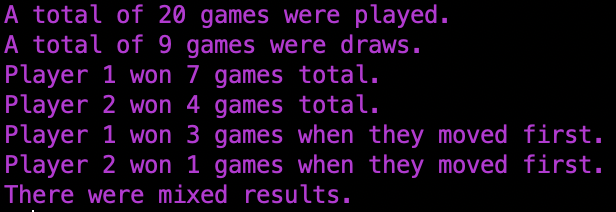

### Against Another Student's Program
When playing my program against another student's program, mine actually ended up winning every single time, just like against the naive player. This also happens consistently.  

I think this is the case because of my center of board favoring heuristic. This heurisitc, along with the alpha-beta pruning, gives me a significant advantage to where my program decides to place it's next move.  

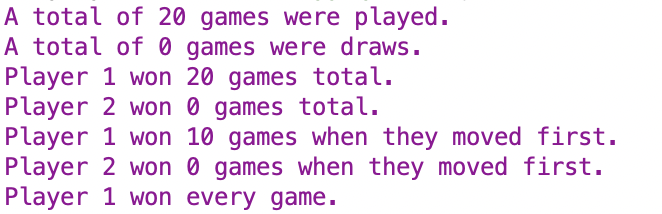

# Conclusion

In conclusion, this Connect Four AI demonstrates the effectiveness of alpha-beta pruning in enhancing decision-making speed and accuracy by eliminating non-viable moves. Testing against different opponents showed that the AI consistently outperformed both a naive player and another student's program due to the strategic advantage provided by its center-favoring heuristic. Against itself, the program often resulted in draws, underscoring the heuristic's emphasis on board control rather than outright winning. Overall, the AI's ability to compete across board sizes and skill levels highlights the strength of its pruning and heuristic-based strategy.